# Supernova Time Series Estimation

## Parameters for &ldquo;Data&rdquo; Generation

To validate the procedure, we first make fake data for it to process.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

region_size = 15 # the number of pixels (width and height) of the region being fitted

nights = 6 # the number of nights for which the supernova was observed

nightly_fwhm = [5.5, 7.5, 5.0, 5.0, 6.5, 6.0] # the fwhm (determined from elsewhere in the image)

# The parameters to be fit that are fixed from night to night (prefixed with f_):

(
    f_a1, f_ax, f_ay, # constant and linear galactic background
    f_axx, f_axy, f_ayy, # quadratic galactic background
    f_x, f_y, # position of supernova within region
) = (
    15.0, 5.5, 10.5,
    -15.5, 15.5, 12.5,
    6.5, 7.5,
)

# The parameters to be fit that vary from night to night (prefixed with v_):

v_h = [90.0 - 8.0 * (night - 2)**2 for night in range(nights)] # supernova brightness

# The above creates this time series: [58.0, 82.0, 90.0, 82.0, 58.0, 18.0]

## Generate &ldquo;Data&rdquo; to be Fit

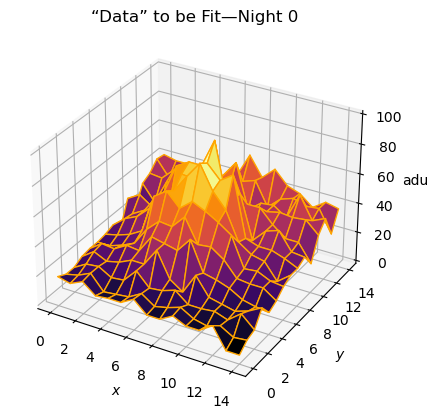

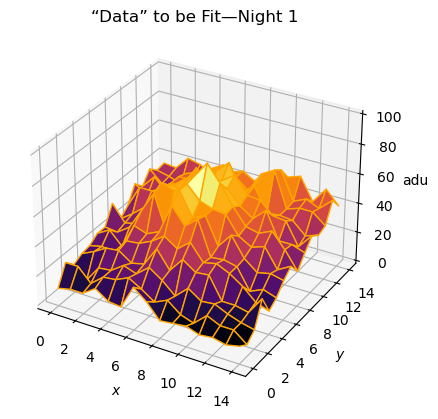

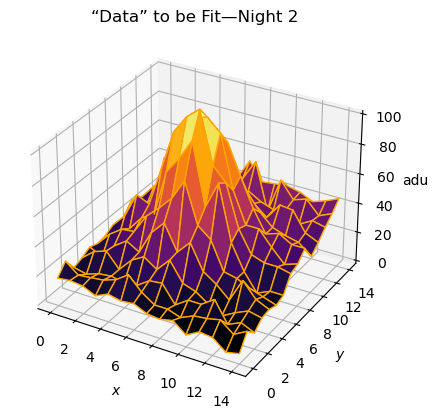

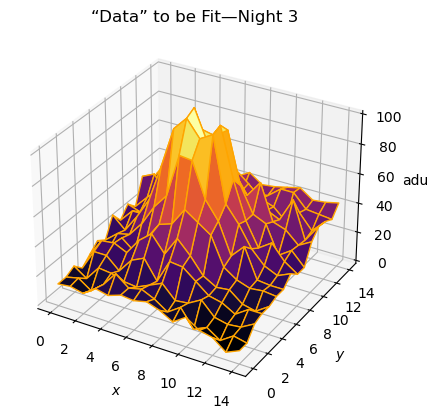

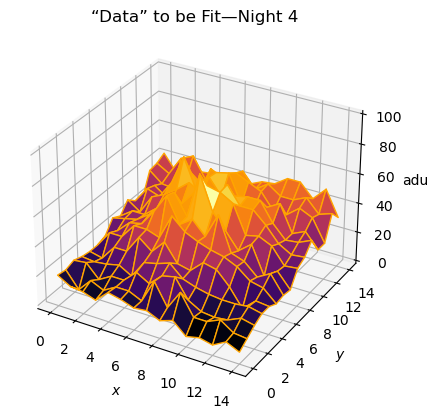

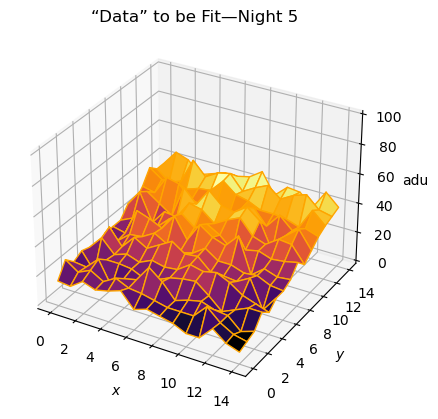

In [2]:
# centered_seeing_function is normalized a little oddly....it has max 1 at x=y=0 if fwhm is 5.0.
# It is normalized to have the same integrated flux for other values of sigma_squared.

reference_fwhm = 5.0

def centered_seeing_function(fwhm, x, y):
    sigma_squared = (fwhm / 2)**2 / math.log(2)
    distance_squared = x**2 + y**2
    return (reference_fwhm / fwhm)**2 * math.exp(-distance_squared / sigma_squared)

def make_model(fwhm, background, x_slope, y_slope, axx, axy, ayy, height, x_pos, y_pos):
    def model(x, y):
        return (
            background + x_slope * x / region_size + y_slope * y / region_size + # constant and linear
            axx * x**2 / region_size**2 + axy * x * y / region_size**2 + ayy * y**2 / region_size**2 + # quadratic
            height * centered_seeing_function(fwhm, x - x_pos, y - y_pos) # supernova
        )

    return model

time_series_generator = [
    make_model(nightly_fwhm[night], f_a1, f_ax, f_ay, f_axx, f_axy, f_ayy, v_h[night], f_x, f_y)
    for night in range(nights)
]

x_positions = range(region_size)
y_positions = range(region_size)

sampled_series = [
    [[np.random.poisson(time_series_generator[night](j, k)) for j in x_positions] for k in y_positions]
    for night in range(nights)
]

x = np.outer(x_positions, np.ones(region_size)).T
y = np.outer(y_positions, np.ones(region_size))

data = np.array(sampled_series) # the data is now in a numpy cube with axes (night, y, x)

for night in range(nights):
    # syntax for 3-D plotting
    axes = plt.axes(projection='3d')
    axes.set_xlabel('$x$')
    axes.set_ylabel('$y$')
    axes.set_zlabel('adu')
    axes.plot_surface(x, y, data[night], cmap='inferno', edgecolor='orange')
    axes.set_title(u'\u201cData\u201d to be Fit\u2014Night ' + str(night))
    axes.axes.set_zlim3d(bottom=0, top=100)

    plt.show()

# The numpy convention when converting a nested list to an array is
# that the most-rapidly varying index stays last, which sort of makes sense,
# because that is the way nested lists work.
#
# To be concrete, in case the preceding description of the numpy convention was
# inscrutable, consider sampled_series[0][inty][intx)] and data[0][inty, intx]
# and compare it with model(intx, inty):

# night = 0
# intx = int(f_x)
# inty = int(f_y)

# (
#     sampled_series[night][inty][intx], # first night's data at (intx, inty)
#     data[night][inty, intx], # exact same thing, but converted to a numpy array
#     time_series_generator[night](intx, inty) # notice the ordering of indices
# )

# The first two values will be identical, and except for Poisson noise they
# will agree with the third.

## Use scipy.optimize to &ldquo;Discover&rdquo; the Time Series in this &ldquo;Data&rdquo;

In [3]:
def variance(models, data):
    shape = data.shape
    sum = 0.0
    for night in range(shape[0]):
        model = models[night]
        for k in range(shape[1]):
            for j in range(shape[2]):
                difference = model(j, k) - data[night, k, j]
                sum += difference**2
    return sum


In [4]:
BACKGROUND_PARAMETER_INDEX = 0
LINX_SLOPE_PARAMETER_INDEX = 1
LINY_SLOPE_PARAMETER_INDEX = 2
QUDXX_COEF_PARAMETER_INDEX = 3
QUDXY_COEF_PARAMETER_INDEX = 4
QUDYY_COEF_PARAMETER_INDEX = 5
POSITION_X_PARAMETER_INDEX = 6
POSITION_Y_PARAMETER_INDEX = 7
REMAINING_PARAMETERS_INDEX = 8

def objective_function(model_parameters, data):
    background = model_parameters[BACKGROUND_PARAMETER_INDEX]
    linx_slope = model_parameters[LINX_SLOPE_PARAMETER_INDEX]
    liny_slope = model_parameters[LINY_SLOPE_PARAMETER_INDEX]
    qudxx_coef = model_parameters[QUDXX_COEF_PARAMETER_INDEX]
    qudxy_coef = model_parameters[QUDXY_COEF_PARAMETER_INDEX]
    qudyy_coef = model_parameters[QUDYY_COEF_PARAMETER_INDEX]
    position_x = model_parameters[POSITION_X_PARAMETER_INDEX]
    position_y = model_parameters[POSITION_Y_PARAMETER_INDEX]
    models = [
        make_model(nightly_fwhm[night],
                   background,
                   linx_slope, liny_slope,
                   qudxx_coef, qudxy_coef, qudyy_coef,
                   model_parameters[REMAINING_PARAMETERS_INDEX + night], position_x, position_y)
        for night in range(nights)
    ]
    return variance(models, data)


## Make our Initial Guesses

In [5]:
background0 = np.median(data)
peak_pixel0 = 25.0
position_x0 = 7.0
position_y0 = 7.0

x0 = np.zeros(REMAINING_PARAMETERS_INDEX + nights)

x0[BACKGROUND_PARAMETER_INDEX] = background0
x0[POSITION_X_PARAMETER_INDEX] = position_x0
x0[POSITION_Y_PARAMETER_INDEX] = position_y0

for night in range(nights):
    x0[REMAINING_PARAMETERS_INDEX + night] = peak_pixel0

In [6]:
from scipy.optimize import minimize

result = minimize(objective_function, x0=x0, args=(data,)).x

background = result[BACKGROUND_PARAMETER_INDEX]
linx_slope = result[LINX_SLOPE_PARAMETER_INDEX]
liny_slope = result[LINY_SLOPE_PARAMETER_INDEX]
qudxx_coef = result[QUDXX_COEF_PARAMETER_INDEX]
qudxy_coef = result[QUDXY_COEF_PARAMETER_INDEX]
qudyy_coef = result[QUDYY_COEF_PARAMETER_INDEX]
position_x = result[POSITION_X_PARAMETER_INDEX]
position_y = result[POSITION_Y_PARAMETER_INDEX]

time_series = result[REMAINING_PARAMETERS_INDEX:]

## Compare the Injected Values with the &ldquo;Discovered&rdquo; Ones

In [7]:
# Comparison between fit and injected for the parameters that do not vary from night to night

(
    (background, linx_slope, liny_slope, qudxx_coef, qudxy_coef, qudyy_coef, position_x, position_y),
     'vs.',
    (f_a1, f_ax, f_ay, f_axx, f_axy, f_ayy, f_x, f_y),

)

((14.998456356843702,
  7.360416540902921,
  10.58849627137442,
  -17.40128077055905,
  16.484029934068843,
  12.000268405440377,
  6.550085936305857,
  7.544781581418547),
 'vs.',
 (15.0, 5.5, 10.5, -15.5, 15.5, 12.5, 6.5, 7.5))

In [8]:
# Comparison between fit and injected for the parameters that varies from night to night.
# These are the fitted values of most interest.

(
    time_series,
    'vs.',
    v_h
)

(array([59.06006599, 80.95338098, 87.59247927, 82.07124131, 54.66477206,
        12.96787143]),
 'vs.',
 [58.0, 82.0, 90.0, 82.0, 58.0, 18.0])

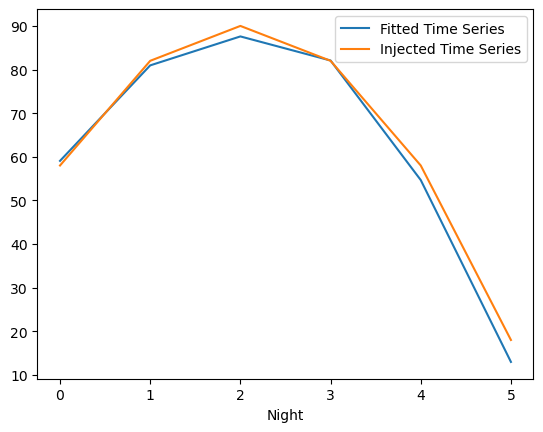

In [9]:
axes = plt.axes()
axes.set_xlabel('Night')
axes.plot(range(nights), time_series, label="Fitted Time Series")
axes.plot(range(nights), v_h, label="Injected Time Series")
axes.legend(loc="upper right")
plt.show()